In [1]:
%load_ext autoreload
%autoreload 2

from mapper import map_anywhere as mpa
from mapper import graph_node, build_node_graph, extract_segments, filter_tree, break_loops
from osrm_interface import osrm_handler

import osmium
import shapely.geometry as geom
from shapely.ops import unary_union
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import numpy as np
import pickle

In [2]:
# Simple example
dest_latlon = (47.635639, -122.105031) # Reid and Emma
# dest_latlon = (47.752200, -122.317425) # Rachel and Nikole
# dest_latlon = (36.970433, -122.007613) # Cayla
nw_latlon = (48.954886, -125.652977)
se_latlon = (31.133894, -105.457201)

# width = 5.0 # deg
# height = 5.0 # deg

router = mpa()
router.set_destination(dest_latlon)
# router.set_bounding_box_centered(width, height)
router.set_bounding_box(nw_latlon, se_latlon)
router.sample_nodes(40000)
router.sample_routes()

Route not found! NoRoute
Warning! No route found! Start_loc: 7914391900 @ latlon (40.087762, -113.319132)
Route not found! NoRoute
Warning! No route found! Start_loc: 4552480372 @ latlon (40.032744, -112.9927)
Route not found! NoRoute
Warning! No route found! Start_loc: 83946722 @ latlon (40.124356, -113.335098)
Route not found! NoRoute
Warning! No route found! Start_loc: 83946705 @ latlon (40.104896, -113.327356)
Route not found! NoRoute
Warning! No route found! Start_loc: 11244701800 @ latlon (40.093703, -113.174757)
Route not found! NoRoute
Warning! No route found! Start_loc: 4534561737 @ latlon (40.100053, -113.081083)
Route not found! NoRoute
Warning! No route found! Start_loc: 11244573940 @ latlon (40.097822, -112.981803)
Route not found! NoRoute
Warning! No route found! Start_loc: 11244573850 @ latlon (40.096443, -112.919072)
Route not found! NoRoute
Warning! No route found! Start_loc: 458716338 @ latlon (40.158553, -113.350607)
Route not found! NoRoute
Warning! No route found! 

In [3]:
print(len(router.node_dict))
print(len(router.segment_counts))

32443
5254774


In [4]:
tree = build_node_graph(router.segment_counts)
filter_tree(tree)
segments = extract_segments(tree)
segments += break_loops(tree)
segments += extract_segments(tree)

Tree is not empty!!!
Found a loop at node 4272310025
Found a loop at node 4272310012
Found a loop at node 3993260349
Found a loop at node 2095680774
Found a loop at node 1409083633
Found a loop at node 122610168
Found a loop at node 1783216986


In [5]:
node_set = set()
for n1n2 in router.segment_counts:
    n1, n2 = n1n2
    node_set.add(n1)
    node_set.add(n2)

In [6]:
# # Parse PBF to get node coordinates
# class NodeHandler(osmium.SimpleHandler):
#     def __init__(self, node_set):
#         super().__init__()
#         self.nodes = {}
#         self.node_set = node_set
    
#     def node(self, n):
#         if n.id in self.node_set:
#             self.nodes[n.id] = (n.location.lon, n.location.lat)

In [7]:
# handler = NodeHandler(node_set)
# # handler.apply_file("washington-250930.osm.pbf")
# handler.apply_file("us-west-250930.osm.pbf")
# nodes_lonlat = handler.nodes

In [ ]:
# Load the node --> latlon database
pbf_file = "us-west-250930.osm.pbf"
pickle_file = file = f"{pbf_file}.p"

with open(pickle_file, 'rb') as f:
    nodes_lonlat = pickle.load(f)

In [8]:
k = next(iter(nodes_lonlat))
nodes_lonlat[k]

(-118.3934517, 33.9807132)

In [9]:
# Need to extract segments
class segment_t():
    def __init__(self, seg_list, nodes_lonlat):
        # self.weight = np.log(seg_list[0] + 1)
        self.weight = (seg_list[0]) ** 0.25
        self.nodes = seg_list[1]
        self.lon = [nodes_lonlat[n][0] for n in self.nodes]
        self.lat = [nodes_lonlat[n][1] for n in self.nodes]

In [10]:
segment_list = [segment_t(s, nodes_lonlat) for s in segments]

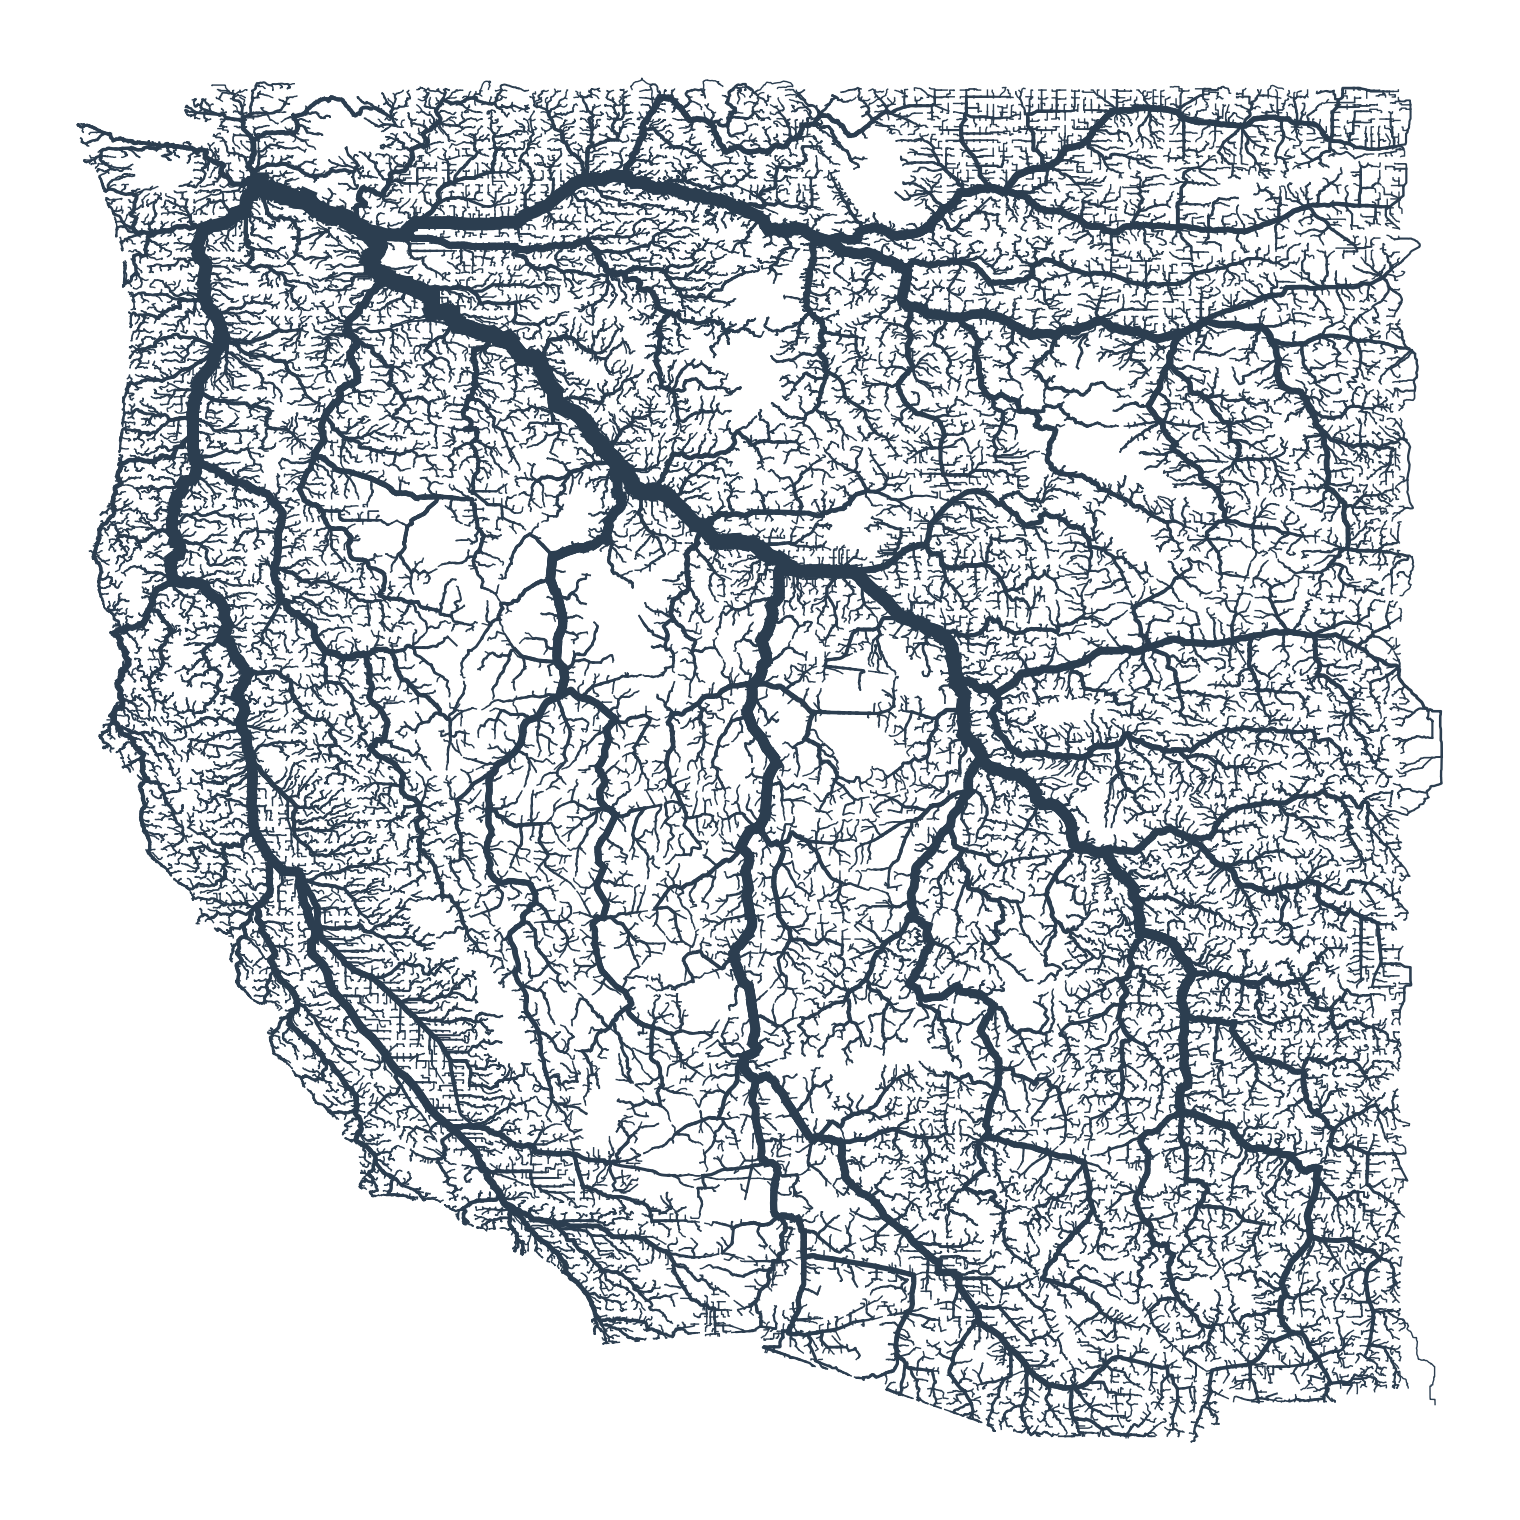

In [13]:
# Plot things, hopefully aesthetically nicely
fig, ax = plt.subplots(figsize=(15, 15), dpi=100)
# ax.set_aspect('equal')

linewidth_scale = 1
for segment in segment_list:
    plt.plot(segment.lon, segment.lat, color='#2C3E50', alpha=1.0, linewidth=segment.weight*linewidth_scale, antialiased=True)

padding = 1.1
# if nw_latlon is not None:
#     pad_w = (se_latlon[1] - nw_latlon[1]) * padding / 2
#     pad_h = (nw_latlon[0] - se_latlon[0]) * padding / 2
#     plt.xlim([nw_latlon[1] - pad_w, se_latlon[1] + pad_w])
#     plt.ylim([se_latlon[0] - pad_h, se_latlon[0] + pad_h])
# else:
#     plt.xlim([dest_latlon[1] - padding * width/2, dest_latlon[1] + padding * width/2])
#     plt.ylim([dest_latlon[0] - padding * height/2, dest_latlon[0] + padding * height/2])

# Styling for aesthetic output
ax.set_facecolor('#ECF0F1')  # Light background
ax.axis('off')
plt.tight_layout(pad=0)
plt.savefig('output.png', dpi=600, bbox_inches='tight', facecolor='#ECF0F1')
plt.show()

In [2]:
class WayNodeHandler(osmium.SimpleHandler):
    def __init__(self):
        super().__init__()
        self.nodes = {}
    
    def way(self, w):
        if 'highway' in w.tags:
            for n in w.nodes:
                self.nodes[n.ref] = (n.location.lon, n.location.lat)

In [4]:
handler = WayNodeHandler()
# handler.apply_file("washington-250930.osm.pbf", locations=True)
pbf_file = "us-west-250930.osm.pbf"
handler.apply_file(pbf_file, locations=True)

In [5]:
import pickle

file = f"{pbf_file}.p"

with open(file, 'wb') as f:
    pickle.dump(handler.nodes, f)

# Later, load instantly
with open(file, 'rb') as f:
    latlon_dict = pickle.load(f)